In [3]:
import torch
import torch.nn as nn

from hvsrUNet.module.model import UNet
from hvsrUNet.module.trainer import train
from hvsrUNet.module.dataset import MkData
from hvsrUNet.toolbox.plot import plotTest, plotLoss, plotHVSR, plotModel
from hvsrUNet.toolbox.hvsrIO import saveModel, loadModel

## Make Dataset

In [ ]:
## 计算瑞雷波/勒夫波前三个阶次的相速度频散曲线(根据输入模型计算理论频散曲线)
import numpy as np
from disba import PhaseDispersion           #计算相速度频散
#from disba import GroupDispersion          #计算群速度频散
from disba._helpers import resample 
import matplotlib
from matplotlib import pyplot as plt
import os


def get_velocity_model(H1, H2, H3, v1, v2, v3):
    velocity_model = np.array([
    [H1, 2*v1, v1, 2.00],
    [H2, 2*v2, v2, 2.00],
    [H3, 2*v3, v3, 2.00]
    ])

    ## 0.1.对原始速度模型进行重采样
    dz = 0.005

    velocity_model_thickness=velocity_model.T[0]
    velocity_model = resample(velocity_model_thickness.T, velocity_model, dz)
    velocity_model = np.array(velocity_model[1])
    velocity_model.T[0] = dz


    # Periods must be sorted starting with low periods
    t = np.logspace(-1.0, 1.0, 1000)          #创建等比数列(周期)
    #t = np.linspace(0.0, 3.0, 100)
    # Compute the 3 first Rayleigh- and Love- wave modal dispersion curves 计R/L频散曲线
    # Fundamental mode corresponds to mode 0(基阶mode=0)
    pd = PhaseDispersion(*velocity_model.T)
    #pd = GroupDispersion(*velocity_model.T)
    #cpr = [pd(t, mode=i, wave="rayleigh") for i in range(3)]
    cpr = pd(t, mode=0, wave="rayleigh")
    #cpl = [pd(t, mode=i, wave="love") for i in range(3)]

    return cpr


depth_end = 0.20

vv1 = np.arange(0.2, 0.4, 0.05)
vv2 = np.arange(0.4, 0.6, 0.05)
vv3 = np.arange(0.6, 0.7, 0.05)
HH1 = np.arange(0.03, 0.09, 0.01)
HH2 = np.arange(0.03, 0.09, 0.01)

dx = int(1000/depth_end)

v = np.zeros(1000)
os.remove('cpr.disp'); os.remove('cpr.vs')
with open('cpr.disp', 'wb') as f1:
    with open('cpr.vs', 'wb') as f2:
        with open('cpr.time', 'wb') as f3:
            for ii, h1 in enumerate(HH1):
                for jj, h2 in enumerate(HH2):
                    for i, v1 in enumerate(vv1):
                        for j, v2 in enumerate(vv2):
                            for k, v3 in enumerate(vv3):
                                H3 = depth_end - h1 - h2
                                # thickness, Vp, Vs, density
                                # km, km/s, km/s, g/cm3

                                try:
                                    a = get_velocity_model(round(h1,2), round(h2,2), round(H3,2), \
                                                        round(v1,2), round(v2,2), round(v3,2))
                                except :
                                    print("***", h1, h2, H3, v1, v2, v3)
                                    continue
                                v[:int(h1*dx)] = v1
                                v[int(h1*dx):int((h1+h2)*dx)] = v2
                                v[int((h1+h2)*dx):] = v3
                                f1.write(a[1].tobytes())
                                f2.write(v.tobytes())
                                f3.write(a[0].tobytes())


In [8]:
from typing import Any
from sklearn.model_selection import train_test_split
import torch
import numpy as np

vs = np.fromfile('../data/cpr.vs', dtype=np.float64).reshape(-1, 1000)
disp = np.fromfile('../data/cpr.disp', dtype=np.float64).reshape(-1, 1000)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(disp, vs, test_size=0.3, random_state=42)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

X_train = torch.unsqueeze(X_train, dim=1)
X_train = torch.unsqueeze(X_train, dim=2)

X_test = torch.unsqueeze(X_test, dim=1)
X_test = torch.unsqueeze(X_test, dim=2)

y_train = torch.unsqueeze(y_train, dim=1)
y_train = torch.unsqueeze(y_train, dim=2)

y_test = torch.unsqueeze(y_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=2)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)  
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


## Model

In [9]:
# define model
model = nn.Sequential(
    UNet(1, 1)
    )

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Train

In [97]:
# train 
epochs = 50
model, losses = train(model, criterion, optimizer, train_iter, num_epochs=epochs)

Epoch [1/50], Iteration [1/25], Loss: 0.3727
Epoch [1/50], Iteration [11/25], Loss: 0.1133
Epoch [1/50], Iteration [21/25], Loss: 0.0453
Epoch [2/50], Iteration [1/25], Loss: 0.0347
Epoch [2/50], Iteration [11/25], Loss: 0.0214
Epoch [2/50], Iteration [21/25], Loss: 0.0136
Epoch [3/50], Iteration [1/25], Loss: 0.0100
Epoch [3/50], Iteration [11/25], Loss: 0.0101
Epoch [3/50], Iteration [21/25], Loss: 0.0102
Epoch [4/50], Iteration [1/25], Loss: 0.0078
Epoch [4/50], Iteration [11/25], Loss: 0.0073
Epoch [4/50], Iteration [21/25], Loss: 0.0063
Epoch [5/50], Iteration [1/25], Loss: 0.0062
Epoch [5/50], Iteration [11/25], Loss: 0.0053
Epoch [5/50], Iteration [21/25], Loss: 0.0061
Epoch [6/50], Iteration [1/25], Loss: 0.0078
Epoch [6/50], Iteration [11/25], Loss: 0.0051
Epoch [6/50], Iteration [21/25], Loss: 0.0048
Epoch [7/50], Iteration [1/25], Loss: 0.0045
Epoch [7/50], Iteration [11/25], Loss: 0.0046
Epoch [7/50], Iteration [21/25], Loss: 0.0055
Epoch [8/50], Iteration [1/25], Loss: 0.0

In [67]:
## model parameters pt file name: freqs_end, num_v1, num_v2, num_v3, num_h1, num_h2, sampleNum, num_data
#                                 10.        4.      8.      2.     20.      20.     5.         1000
#saveModel(model, optimizer, epochs, losses, '../data/10_4_8_2_20_20_5_1000.pt')
#torch.save(model, '../parameter/disp.pt')
#model = torch.load('../parameter/disp.pt')
# model, optimizer, epochs, losses = loadModel(model, optimizer, '../data/10_4_8_2_20_20_5_1000.pt')

In [10]:
model = nn.Sequential(
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU()
    )


In [11]:
# train 
epochs = 50
model, losses = train(model, criterion, optimizer, train_iter, num_epochs=epochs)

Epoch [1/50], Iteration [1/25], Loss: 0.2385
Epoch [1/50], Iteration [11/25], Loss: 0.2476
Epoch [1/50], Iteration [21/25], Loss: 0.2517
Epoch [2/50], Iteration [1/25], Loss: 0.2280
Epoch [2/50], Iteration [11/25], Loss: 0.2345
Epoch [2/50], Iteration [21/25], Loss: 0.2411
Epoch [3/50], Iteration [1/25], Loss: 0.2480
Epoch [3/50], Iteration [11/25], Loss: 0.2363
Epoch [3/50], Iteration [21/25], Loss: 0.2383
Epoch [4/50], Iteration [1/25], Loss: 0.2378
Epoch [4/50], Iteration [11/25], Loss: 0.2481
Epoch [4/50], Iteration [21/25], Loss: 0.2422
Epoch [5/50], Iteration [1/25], Loss: 0.2478
Epoch [5/50], Iteration [11/25], Loss: 0.2443
Epoch [5/50], Iteration [21/25], Loss: 0.2431
Epoch [6/50], Iteration [1/25], Loss: 0.2460
Epoch [6/50], Iteration [11/25], Loss: 0.2319
Epoch [6/50], Iteration [21/25], Loss: 0.2403
Epoch [7/50], Iteration [1/25], Loss: 0.2510
Epoch [7/50], Iteration [11/25], Loss: 0.2367
Epoch [7/50], Iteration [21/25], Loss: 0.2402
Epoch [8/50], Iteration [1/25], Loss: 0.2

## Test

In [68]:
import matplotlib.pyplot as plt
import numpy as np

X = X_test[:30]; y = y_test[:30]

y_pred = model(X)
y_pred = y_pred.detach().numpy()

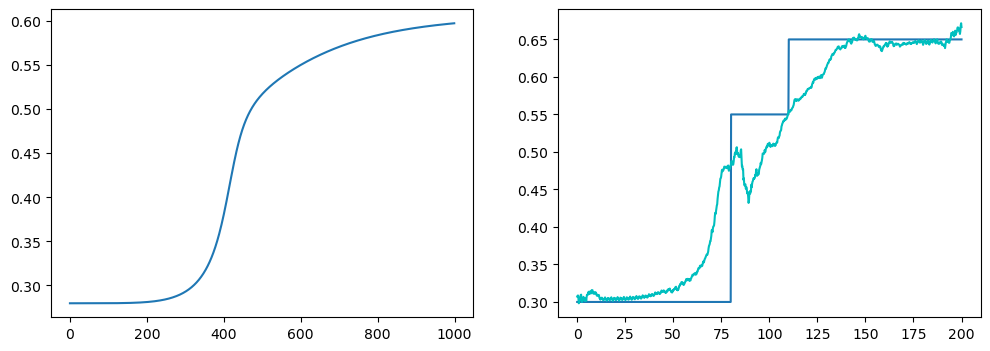

In [94]:
i = np.random.randint(0, 30)

# 定义移动平均滤波器的窗口大小
window_size = 20

# 构建移动平均滤波器的系数
b = np.ones(window_size) / window_size

# 对信号进行滤波
yy = np.convolve(y_pred[i][0][0], b, mode='valid')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(X[i, 0, 0, :], label='true')
ax2.plot(np.linspace(0, 200, len(y[i, 0, 0])), y[i, 0, 0, :], label='pred')
ax2.plot(np.linspace(0, 200, len(yy)), yy, label='Predicted Thickness', color='c')
# ax2.set_title('Predicted Thickness')
# ax2.set_xlabel('Depth [m]')
# ax2.set_ylabel('Velocity [m/s]')

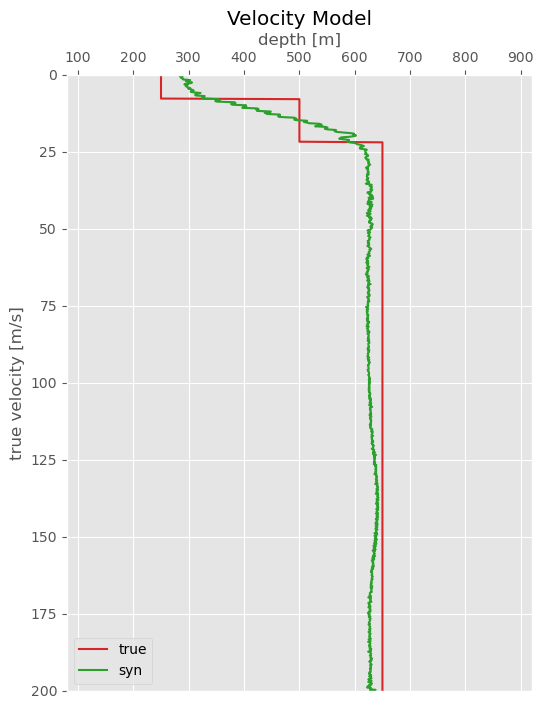

In [21]:
depth_end = 200.
freqs_end = 10.

X, y = next(iter(test_iter))
yyy = model(X)
j = 11

true_v = 100*y[j][0][0].detach().numpy()
syn_v = 100*yyy[j][0][0].detach().numpy()
depth = torch.linspace(0, depth_end, len(true_v))
freq = torch.linspace(0, freqs_end, len(true_v))


with plt.style.context('ggplot'):

    # 创建图形和坐标轴对象
    fig, ax = plt.subplots(figsize=(6, 8))

    ax.plot(true_v, depth, label='true', color='tab:red')
    ax.plot(syn_v, depth, label= 'syn', color='tab:green')


    # 设置 y 轴刻度方向
    ax.yaxis.tick_left()
    #ax.yaxis.set_label_position('top')
    ax.set_xlabel('depth [m]')
    ax.set_ylabel('true velocity [m/s]')
    # 设置坐标轴位置
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_ylim([0, 200])
    ax.set_xlim([80, 920])
    ax.legend(loc='lower left')
    ax.set_title('Velocity Model')

    # 反转y轴
    ax.invert_yaxis()
    #plt.show()


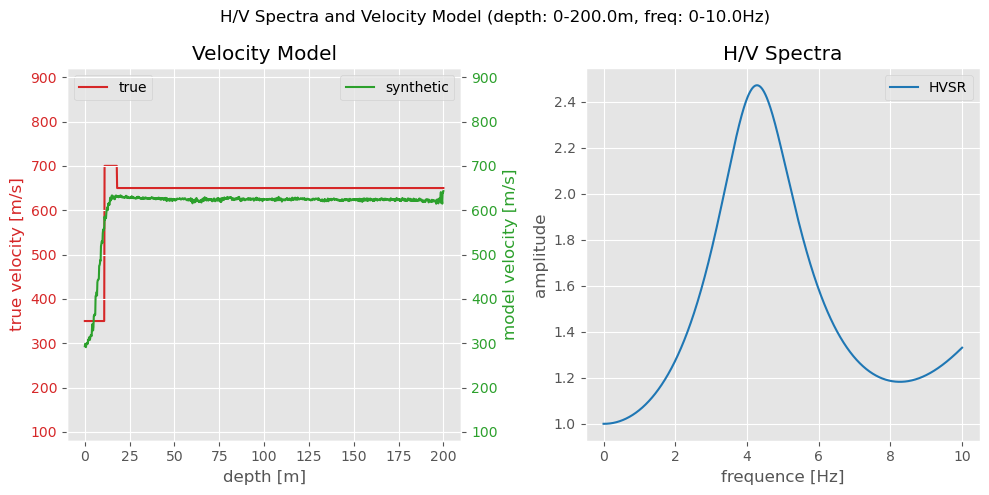

In [37]:
plotTest(model, test_iter, depth_end=200., freqs_end=10)


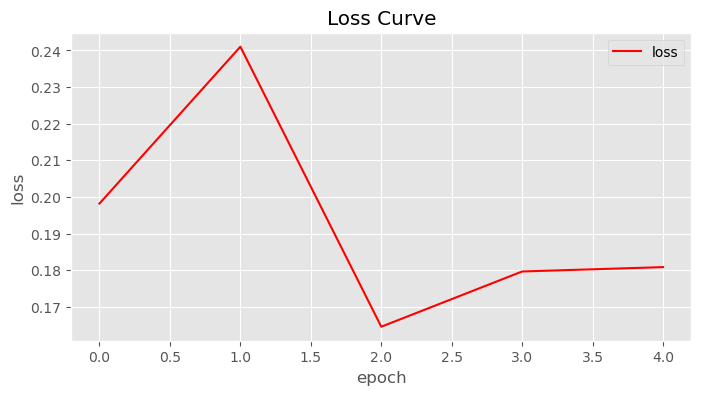

In [38]:
plotLoss(losses)

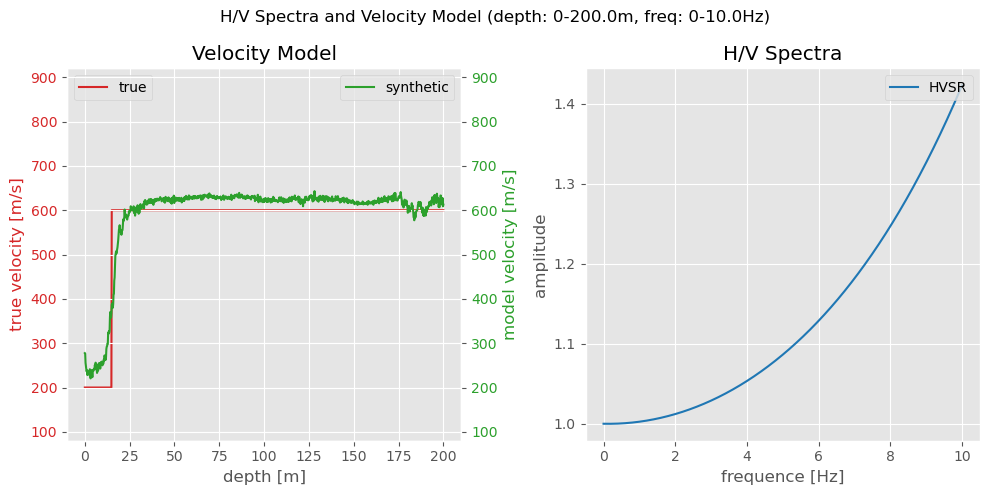

In [13]:
plotTest(model, test_iter, depth_end=200., freqs_end=10)

In [8]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt



hv_true = np.loadtxt('S0460a_VEL.hv')
#hv_true = signal.resample(hv_true, 512)

In [9]:
X, yy = next(iter(test_iter))

hv = torch.tensor(hv_true[:, 0], dtype=torch.float32)
hv = hv.reshape(1, 1, 1, len(hv_true[:, 0]))
hv = torch.cat((hv, hv), dim=0)

y = model(hv)

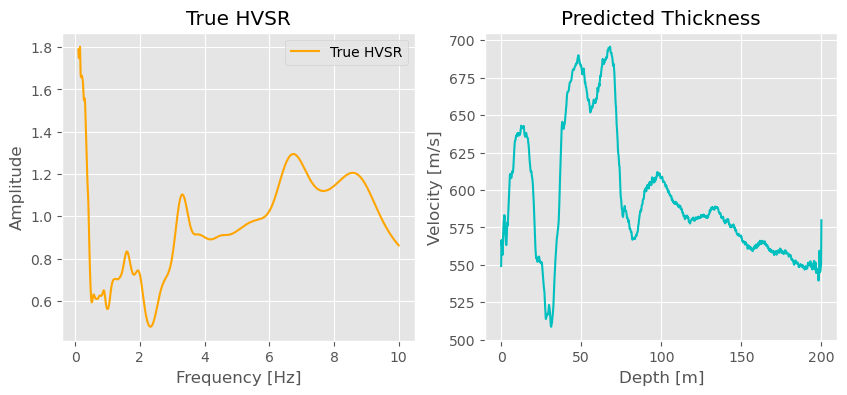

In [19]:
with plt.style.context('ggplot'):
#with plt.style.context('../hvsrUNet/toolbox/tm.mplstyle'):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(hv_true[:, 0], hv_true[:, 1], label='True HVSR', color='orange')
    ax1.set_title('True HVSR')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Amplitude')
    ax1.legend(loc='upper right')


    # 定义移动平均滤波器的窗口大小
    window_size = 10

    # 构建移动平均滤波器的系数
    b = np.ones(window_size) / window_size

    # 对信号进行滤波
    yy = np.convolve(y[0][0][0].detach().numpy(), b, mode='valid')

    ax2 = fig.add_subplot(1, 2, 2)
    #ax2.plot(np.linspace(0, 200, 1000), 100*y[0][0][0].detach().numpy(), label='Predicted Thickness', color='green')
    ax2.plot(np.linspace(0, 200, len(yy)), 100*yy, label='Predicted Thickness', color='c')
    ax2.set_title('Predicted Thickness')
    ax2.set_xlabel('Depth [m]')
    ax2.set_ylabel('Velocity [m/s]')
    #ax2.legend(loc='upper right')
    # ax2.axvline(x=14, color='r', linestyle='--') #ymin=0.2, ymax=0.8
    # ax2.axvline(x=70, color='k', linestyle='--')
    # ax2.axvline(x=140, color='b', linestyle='--')
    

In [10]:
H = [40, 40, 120]   
Vs = [625, 680, 575]
Den = mkdata.den(Vs)
Damp = mkdata.damp(Vs)
freqs = torch.linspace(0, 10, 1000)


data = mkdata.calc_hvsr(Vs, H, Den, Damp, freqs)

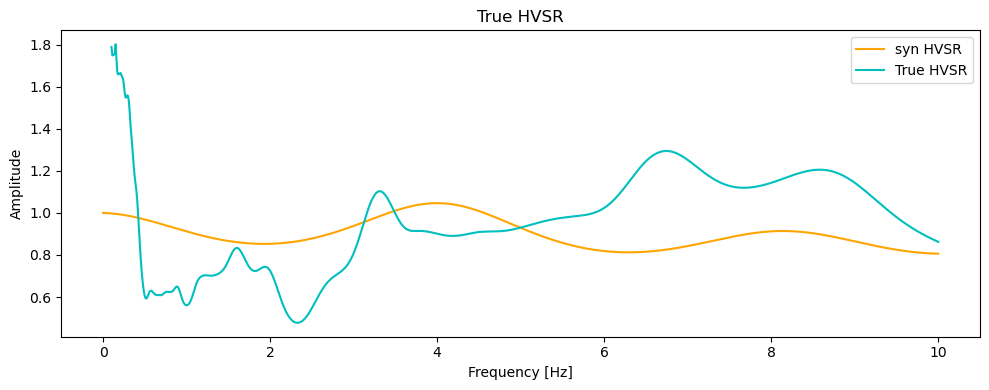

In [26]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 1, 1)
#ax1.errorbar(freqs, data, yerr=0.1, label='syn HVSR', color='orange', capsize=0.001)
ax1.plot(freqs, data, label='syn HVSR', color='orange')
ax1.set_title('True HVSR')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
ax1.legend(loc='upper left')
# # 创建第二个坐标轴
# ax2 = ax1.twinx()
# ax2.plot(hv_true[:, 0], hv_true[:, 1], label='True HVSR', color='c')
# ax2.set_title('True HVSR')
# ax2.set_xlabel('Frequency [Hz]')
# ax2.set_ylabel('Amplitude')
# ax2.legend(loc='upper right')
ax1.plot(hv_true[:, 0], hv_true[:, 1], label='True HVSR', color='c')
ax1.set_title('True HVSR')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
ax1.legend(loc='upper right')
# 调整布局
fig.tight_layout()
# 显示图像
plt.show()